In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import TreeRep
import torch

In [2]:
def poincare_distance(p, q):
    """
    Compute the hyperbolic distance between two points
    on the Poincare disk.
    """
    return np.arccosh(1 + 2*abs(p-q)**2/((1 - abs(p)**2)*(1 - abs(q)**2)))

In [3]:
def reflect(z_0, z):
    """
    Reflect a point z where it reflects z_0 through the origin.
    (i.e., compute r(z) where r(z_0) = 0)
    We need to exclude the case when z_0 = 0.
    """
    beta = z_0 / (z_0.conjugate())
    w = (z_0 - z) / ((1.0+0.0j) - z_0.conjugate() * z)
    return beta * w.conjugate()

In [4]:
def get_distance_matrix(G):
    """
    Compute the distance matrix for a graph.
    """
    n = G.number_of_nodes()
    D = torch.zeros(n, n, dtype = torch.double)
    for i in range(n):
        for j in range(i+1, n):
            D[i,j] = D[j,i] = nx.shortest_path_length(G, source = i, target = j, weight = 'weight')
    return D

In [5]:
def BFS(G, s):
    """
    Perform a breadth-first search on a graph.
    (Not sure if this is the best way to do this, when do we use this?)
    """
    n = G.number_of_nodes()
    visited = torch.zeros(n, dtype = torch.bool)
    children = [ [] for _ in range(n) ]
    order = []
    visited[s] = True
    queue = [s]
    while len(queue) > 0:
        v = queue.pop(0)
        order.append(v)
        for u in G.neighbors(v):
            if visited[u] == False:
                visited[u] = True
                children[v].append(u)
                queue.append(u)
    return order

In [6]:
def sarkar_construction(G, root = 0, scale = 1, weighted = True, set_attribute = True):
    """
    Construct a tree from a graph using the Sarkar algorithm.
    """
    n = G.number_of_nodes()
    embedding = [(0.0 + 0.0j) for _ in range(n)]
    r_0 = np.random.uniform(0, 0.1) # This part is needed to ensure that the root is not on the origin. Can we exclude this?
    theta_0 = np.random.uniform(0, 2*np.pi)
    embedding[root] = r_0*np.cos(theta_0) + r_0*np.sin(theta_0)*1j
    visited = torch.zeros(n, dtype = torch.bool)
    parent = [None for _ in range(n)]
    visited[root] = True
    queue = [root]
    while len(queue) > 0:
        v = queue.pop(0)
        d = 1
        children = []
        for u in G.neighbors(v):
            if visited[u] == False:
                visited[u] = True
                d += 1
                parent[u] = v
                queue.append(u)
                children.append(u)
        if v == root:
            theta = np.random.uniform(0, 2*np.pi)
            m = d - 1
        else:
            w = parent[v]
            z = reflect(embedding[v], embedding[w])
            theta = np.angle(z)
            m = d
        # print("d? = ", d)
        for i in range(d-1):
            child = children[i]
            if weighted:
                tau = scale * G[v][child]['weight']
            else:
                tau = scale
            l = (np.exp(tau) - 1) / (np.exp(tau) + 1)
            eta = theta + 2*np.pi*(i+1)/m
            y = l * np.cos(eta) + l * np.sin(eta)*1j
            embedding[child] = reflect(embedding[v], y)
    if set_attribute:
        pos = {}
        for i in range(n):
            pos[i] = (embedding[i].real, embedding[i].imag)
        nx.set_node_attributes(G, pos, 'pos')
    return embedding
        

In [7]:
n_vertices = 10
D = torch.zeros(n_vertices, n_vertices, dtype = torch.double)
for i in range(n_vertices):
    for j in range(n_vertices):
        D[i,j] = min(abs(i-j), n_vertices-abs(i-j))
T = TreeRep.TreeRep(D)
T.learn_tree()
# get_distance_matrix(T.G)[:n_vertices, :n_vertices] - D

{(0, 11): Text(0.06804720652158323, 0.30772610663758637, '0.25'),
 (1, 10): Text(0.5290176932197882, 0.29604088642806137, '0.5'),
 (2, 3): Text(0.898944440578433, 0.08968341853890902, '1.0'),
 (3, 10): Text(0.6241337376989518, 0.14764830358150982, '0.5'),
 (4, 7): Text(-0.3202025038040341, -0.31508556541865196, '3.0'),
 (5, 7): Text(-0.4356466852217121, -0.29424398551627906, '2.0'),
 (6, 7): Text(-0.4329083139676486, -0.18946851783014224, '1.0'),
 (7, 8): Text(-0.39693453248232113, -0.38264315940415455, '1.0'),
 (7, 12): Text(-0.2831293257506803, -0.16058849502204064, '1.875'),
 (9, 12): Text(-0.4485361593962327, 0.09607004906713185, '0.125'),
 (10, 11): Text(0.27386145373137066, 0.15345269546662357, '0.75'),
 (11, 12): Text(-0.05505088428911357, 0.031038242834039432, '0.875')}

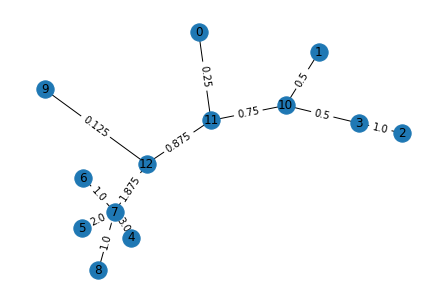

In [8]:
edge_labels = nx.get_edge_attributes(T.G, 'weight')
pos = nx.spring_layout(T.G)
nx.draw(T.G, pos, with_labels = True)
nx.draw_networkx_edge_labels(T.G, pos, edge_labels = edge_labels)

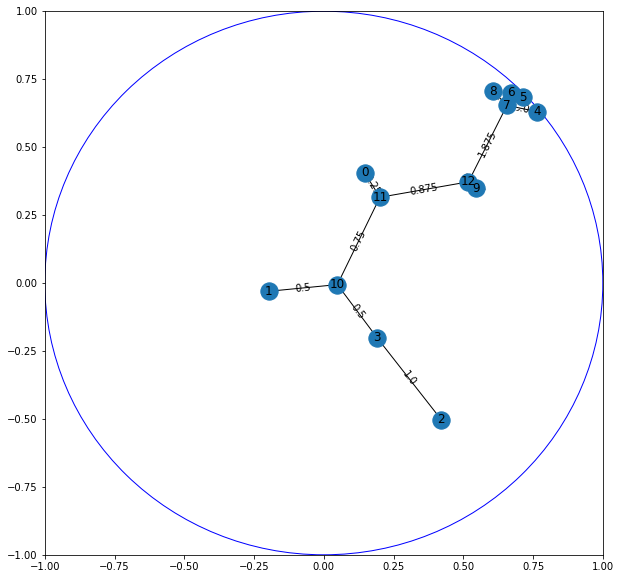

In [9]:
E = sarkar_construction(T.G, root = min(n_vertices, T.G.number_of_nodes() - 1))
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
edge_labels = nx.get_edge_attributes(T.G, 'weight')
pos = nx.get_node_attributes(T.G, 'pos')
nx.draw_networkx_edge_labels(T.G, pos = pos, edge_labels = edge_labels)
nx.draw(T.G, pos = pos, with_labels = True)
plt.axis("on")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
ax.add_patch(circ)
plt.show()